In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import proplot as pplt
import numpy as np
from rolling_plot_utils import (
    plot_years_and_seasons,
    get_season,
    get_cmap_plus_white,
    BASELINE_SURVEY_START_MJD,
    MJD_2024,
    YEAR,
    get_sun_ra_at_mjd,
    plot_sun_ra,
    plot_rizexptime_fancy,
    mad,
)
import fitsio

## Plot to Explain New Rolling

In [ ]:
shift = 0
start_time = BASELINE_SURVEY_START_MJD + shift
n_years = 10

run_time = YEAR * n_years
time_grid = np.linspace(start_time, start_time + run_time, n_years * 1000 + 1)
tv = (time_grid[:-1] + time_grid[1:])/2.0
ra_grid = np.linspace(0, 360, 24*10 + 1)
rav = (ra_grid[:-1] + ra_grid[1:])/2.0

rolling_strength = 0.9
U = 1.0 + rolling_strength
D = 2.0 - U

vmin = 0
vmax = 2

cmap = get_cmap_plus_white(cmap="marine")
ylim = (2024.5, 2036.5)
pfac = 1.5
fig, axs = pplt.subplots(nrows=1, ncols=2, figsize=(4 * pfac, 3 * pfac), sharex=0, sharey=4)

# baseline
pattern   = [1, D, U, D, U, D, U, D, U, 1, 1, 1, 1]
pattern_c = [1, 1, U, D, U, D, U, D, U, D, 1, 1, 1]

pattern = np.array(pattern)
pattern_c = np.array(pattern_c)

seasons = get_season(
    tv.reshape(-1, 1),
    rav.reshape(1, -1),
    start_time,
)
int_seasons = np.floor(seasons).astype(int)
rs = pattern[int_seasons]
rsc = pattern_c[int_seasons]

msk = seasons - int_seasons >= 0.5
rs[~msk] = np.nan
rsc[~msk] = np.nan

ra_sun = get_sun_ra_at_mjd(start_time)
msk = (rav >= 90 + ra_sun) & (rav <= 270 + ra_sun)
for i in range(rs.shape[0]):
    rs[i, msk] = rsc[i, msk]

# seasons = get_season(
#     tv.reshape(-1, 1),
#     rav.reshape(1, -1) + 180,
#     start_time,
# )
# int_seasons = np.floor(seasons).astype(int)
# rs = pattern[int_seasons]
# msk = seasons - int_seasons < 0.5
# rs[~msk] = np.nan

ax = axs[0, 0]
m = ax.pcolormesh(
    ra_grid,
    (time_grid - MJD_2024) / YEAR + 2024,
    rs,
    vmin=vmin,
    vmax=vmax,
    shading="flat",
    # N=max_obs_ints*8,
    cmap=cmap,
    discrete=False,
)
m = plot_years_and_seasons(ax, start_time, n_years)
m += plot_sun_ra(ax, start_time, n_years, label="sun", color="red", linestyle="dashdot")
ax.format(xlabel="ra [deg]", ylabel="year", title="four-cycle rolling", ylim=ylim)
ax.legend(m, loc="ul", frameon=False, ncols=2)

# optimized
pattern_a = [1, D, U, 1, D, U, 1, D, U, 1, 1, 1, 1]
pattern_ac = [1, 1, U, D, 1, U, D, 1, U, D, 1, 1, 1]
pattern_b = [1, U, D, 1, U, D, 1, U, D, 1, 1, 1, 1]
pattern_bc = [1, 1, D, U, 1, D, U, 1, D, U, 1, 1, 1]
pattern_a = np.array(pattern_a)
pattern_b = np.array(pattern_b)
pattern_ac = np.array(pattern_ac)
pattern_bc = np.array(pattern_bc)

seasons = get_season(
    tv.reshape(-1, 1),
    rav.reshape(1, -1),
    start_time,
)
int_seasons = np.floor(seasons).astype(int)
rs = pattern_a[int_seasons]
rsc = pattern_ac[int_seasons]

msk = seasons - int_seasons >= 0.5
rs[~msk] = np.nan
rsc[~msk] = np.nan

ra_sun = get_sun_ra_at_mjd(start_time)
msk = (rav >= 90 + ra_sun) & (rav <= 270 + ra_sun)
for i in range(rs.shape[0]):
    rs[i, msk] = rsc[i, msk]

ax = axs[0, 1]
m = ax.pcolormesh(
    ra_grid,
    (time_grid - MJD_2024) / YEAR + 2024,
    rs,
    vmin=vmin,
    vmax=vmax,
    shading="flat",
    # N=max_obs_ints*8,
    cmap=cmap,
    discrete=False,
)
ax.colorbar(
    m,
    loc="r",
    title="cadence relative to no rolling",
)
plot_years_and_seasons(ax, start_time, n_years)
plot_sun_ra(ax, start_time, n_years, label="sun", color="red", linestyle="dashdot")
ax.format(xlabel="ra [deg]", ylabel="year", title="uniform rolling (baseline)", ylim=ylim)

fig.savefig("rolling_seasons.png", dpi=300)

## Look at Raw Sims

In [ ]:
from rubin_sim.scheduler.utils import SkyAreaGenerator
nside = 128

maps_arr = fitsio.read("four_cycle_v4.0_10yrs_nside128_bins40.fits")

sm = SkyAreaGenerator(nside=nside)
footprints_hp_array, labels = sm.return_maps()
wfd_msk = (labels == 'lowdust') | (labels == 'virgo')


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    fig, axs = pplt.subplots(nrows=40, ncols=1, figsize=(3, 60), proj="moll", share=0)

mind = -1
for ax in axs[:, 0]:
    mind += 1

    hmap = maps_arr[mind, :].copy()
    msk = (~wfd_msk) | (hmap < 15)
    hmap[msk] = np.nan
    print(dict(
        vmin=np.nanmin(hmap),
        vmax=np.nanmax(hmap),
    ))

    plot_rizexptime_fancy(
        ax,
        hmap,
        1.0,
        npix=200,
        vmin=np.nanmin(hmap),
        vmax=np.nanmax(hmap),
        cmap=get_cmap_plus_white(cmap="cubehelix"),
    )


## Viz of Sim results

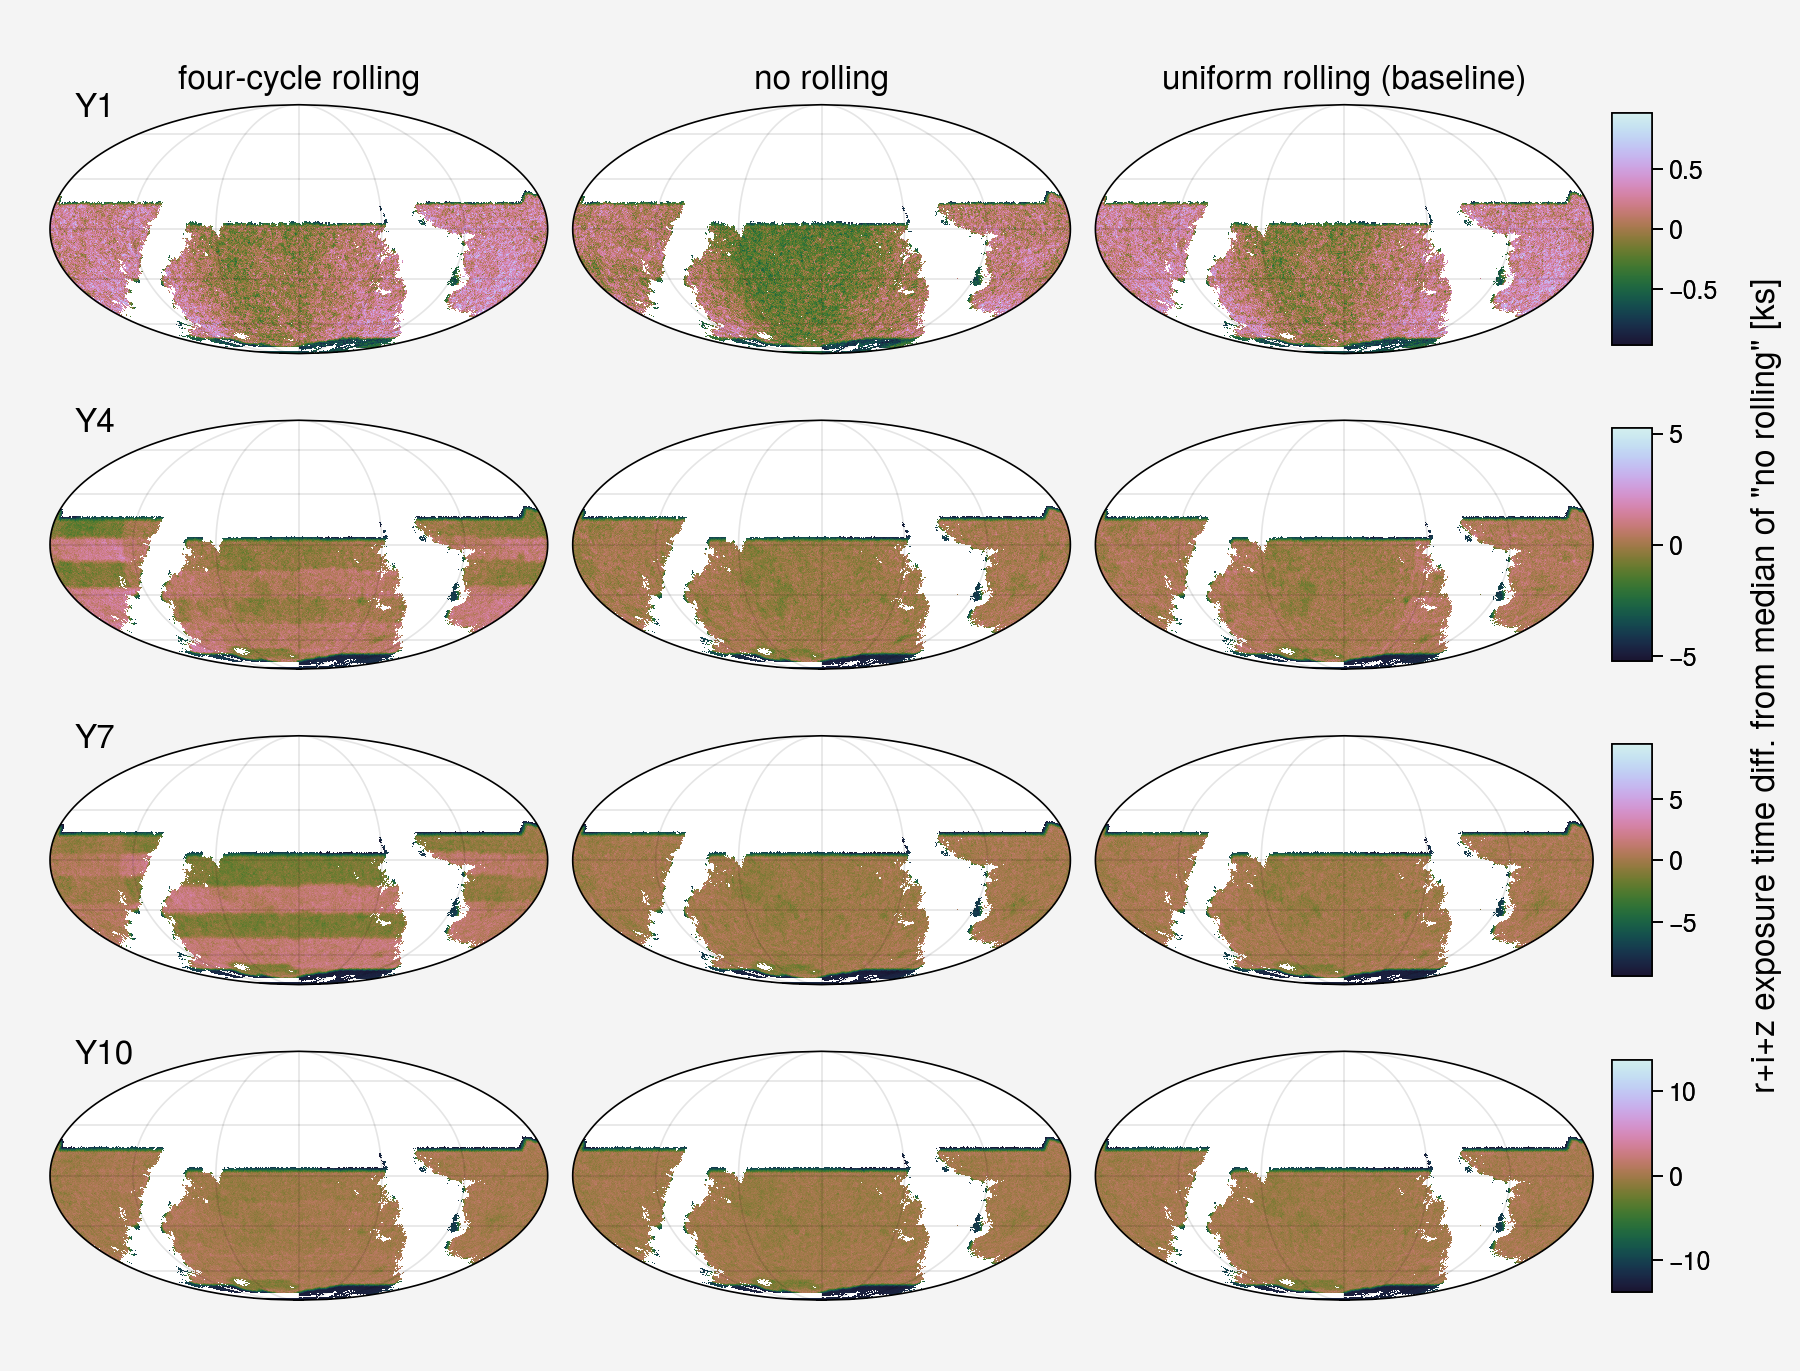

In [3]:
from rubin_sim.scheduler.utils import SkyAreaGenerator

nside = 128

sm = SkyAreaGenerator(nside=nside)
footprints_hp_array, labels = sm.return_maps()
wfd_indx = np.where((labels == 'lowdust') | (labels == 'virgo'))[0]

roll_uniform_maps_arr = fitsio.read("baseline_v4.0_10yrs_nside128_bins40.fits")
uniform_maps_arr = fitsio.read("noroll_v3.6_10yrs_nside128_bins40.fits")
# uniform_maps_arr = uniform_maps_arr / np.sum(uniform_maps_arr) * np.sum(roll_uniform_maps_arr)
baseline_maps_arr = fitsio.read("four_cycle_v4.0_10yrs_nside128_bins40.fits")

map_labels = [
    "four-cycle rolling",
    "no rolling",
    "uniform rolling (baseline)"
]
maps = [
    baseline_maps_arr,
    uniform_maps_arr,
    roll_uniform_maps_arr
]
year_inds = [3, 7, 11, 15, 19, 23, 27, 31, 35, 39]
year_inds = [3, 15, 27, 39]
width = 3 * len(map_labels)
height = width / len(map_labels) / 1.75 * len(year_inds)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

    fig, axs = pplt.subplots(
        nrows=len(year_inds), ncols=3,
        proj="moll",
        figsize=(width, height),
        outerpad=2.0,
    )

for axind, yind in enumerate(year_inds):
    smaps = []
    all_msk = None
    for mind in range(3):
        med_rizexptime_per_year = np.median(uniform_maps_arr[yind, wfd_indx])

        smap = (maps[mind][yind, :] - med_rizexptime_per_year)
        msk = maps[mind][yind, :] < (0 * ((yind + 1)/4))
        if all_msk is None:
            all_msk = msk
        else:
            all_msk |= msk
        smaps.append(smap)

    _smaps = []
    for smap in smaps:
        smap[all_msk] = np.nan
        _smaps.append(smap)
    smaps = _smaps

    smaps = np.array(smaps)
    smaps /= 1e3  # convert to kiloseconds
    msk = np.isfinite(smaps)
    vmax = np.max(np.abs(smaps[msk]))
    smaps[~msk] = -vmax

    for mind in range(3):
        ax = axs[axind, mind]

        m = plot_rizexptime_fancy(
            ax,
            smaps[mind],
            1.0,
            vmin=-vmax, vmax=vmax,
            npix=800,
            cmap=get_cmap_plus_white(cmap="cubehelix"),
        )

        if yind == 3:
            ax.text(
                0.5, 1.1,
                map_labels[mind],
                ha="center",
                va="center",
                transform=ax.transAxes,
                fontsize=12,
            )

        if mind == 0:
            ax.text(
                0.05, 1.05,
                f"Y{yind // 4 + 1}",
                ha="left",
                va="top",
                transform=ax.transAxes,
                fontsize=12,
            )

        if mind == 2:
            ax.colorbar(
                m,
                loc="r",
                length=0.8,
                pad=0.75,
            )

fig.text(
    0.99, 0.5,
    "r+i+z exposure time diff. from median of \"no rolling\" [ks]",
    ha="right",
    va="center",
    transform=fig.transFigure,
    fontsize=12,
    rotation=90,
)

# fig.format(suptitle="r+i+z exposure time in units of LSST Y1 median")

fig.savefig("riz_obstime_maps.png", dpi=300)

## Show Visits per Season

In [ ]:
import warnings

baseline_maps_arr = fitsio.read(
    "four_cycle_v4.0_10yrs_seasons_psqy1_usemafFalse_bandi_nside128.fits"
)
no_roll_maps_arr = fitsio.read(
    "noroll_v3.6_10yrs_seasons_psqy1_usemafFalse_bandi_nside128.fits"
)
roll_uniform_maps_arr = fitsio.read(
    "baseline_v4.0_10yrs_seasons_psqy1_usemafFalse_bandi_nside128.fits"
)


map_labels = [
    "four-cycle rolling",
    "no rolling",
    "uniform rolling (baseline)"
]
maps = [
    baseline_maps_arr,
    no_roll_maps_arr,
    roll_uniform_maps_arr
]

sm = SkyAreaGenerator(nside=nside)
footprints_hp_array, labels = sm.return_maps()
wfd_msk = (labels == 'lowdust') | (labels == 'virgo')

offset = 2
nseasons = 5
width = 3 * len(maps)
height = width / len(maps) / 1.75 * nseasons


smaps = []
for i in range(nseasons):
    # if i != nseasons - 1:
    #     continue
    for j, arr in enumerate(maps):
        smap = arr[i+offset, :].copy()
        msk = (smap < 0) | (~wfd_msk)
        smap[msk] = 0
        smaps.append(smap)

smaps = np.array(smaps)

vmin = 0
vmax = np.nanmedian(smaps[smaps > 0]) * 3


with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    fig, axs = pplt.subplots(
        nrows=nseasons,
        ncols=len(maps),
        figsize=(width, height),
        proj="moll",
        outerpad=2.0,
    )

for i in range(nseasons):
    smaps = []
    for j, arr in enumerate(maps):
        smap = arr[i+offset, :].copy()
        msk = (smap < 0) | (~wfd_msk)
        smap[msk] = 0
        smaps.append(smap)

    smaps = np.array(smaps)

    for j, smap in enumerate(smaps):
        ax = axs[i, j]
        m = plot_rizexptime_fancy(
            ax,
            smap,
            1.0,
            vmin=vmin, vmax=vmax,
            npix=200,
            cmap=get_cmap_plus_white(cmap="cubehelix"),
        )

        if i == 0:
            ax.text(
                0.5, 1.1,
                map_labels[j],
                ha="center",
                va="center",
                transform=ax.transAxes,
                fontsize=12,
            )

        if j == 0:
            ax.text(
                0.05, 1.05,
                f"S{i+1}",
                ha="left",
                va="top",
                transform=ax.transAxes,
                fontsize=12,
            )

        # if j == 2:
        #     ax.colorbar(
        #         m,
        #         loc="r",
        #         length=0.8,
        #         pad=0.75,
        #     )

fig.colorbar(
    m,
    loc="b",
    label="# of visits per season",
    length=0.8,
    ticklabelsize=12,
    labelsize=12,
)

fig.savefig("i_visits_maps.png", dpi=300)